PHYS3116 Computational Assessment 2025: Option 1
Accreted Milky Way Globular Clusters

Alright, here's the deal:
We're digging through a bunch of globular cluster data to figure out which 
ones are OG Milky Way locals and which ones are cosmic hitchhikers 
stolen from dwarf galaxies.

Data we're mashing together:
- Harris Catalogue (Parts I & III) -> positions + kinematics
- VandenBerg et al. (2013) -> ages + metallicities
- Krause et al. (2021) -> shiny updated Gaia-based velocities

The plan:
1. Smash all the catalogues into one big "master" table.
2. Plot an age-metallicity diagram and see which clusters are acting sus.
3. Check their motion to see who's not dancing in sync with the rest of the Milky Way crew.
4. Cross-match the weirdos to build our list of likely accreted clusters.
5. Use that list to tell the story of how the Milky Way bulked up over time.

Endgame:
- A merged dataset
- Some nice plots (with sus clusters circled)
- A few "aha" moments about galactic archaeology
- Content for the 10-minute video presentation

Authors: Deagan Marchant ("Lemon mans")
Date: September 2025

In [340]:
## Starting assessment 1/10/2025
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


In [341]:
# Loading the datasets for the globular clusters
h1 = pd.read_csv("HarrisPartI.csv", dtype=str)
h3 = pd.read_csv("HarrisPartIII.csv", dtype=str)
kr = pd.read_csv("Krause21.csv", dtype=str)
vb = pd.read_csv("vandenBerg_table2.csv", dtype=str)


print(h1.shape, h3.shape, vb.shape, kr.shape)

(157, 11) (157, 13) (55, 13) (61, 8)


In [342]:
print(h1.head()) # checking the data loaded correctly
print(h3.head()) # checking the data loaded correctly
print(kr.head()) # checking the data loaded correctly
print(vb.head()) # checking the data loaded correctly

 
print("Loaded tables:")
print("Harris I:", h1.shape, "Harris III:", h3.shape, "Krause:", kr.shape, "VandenBerg:", vb.shape)

### It works :))

          ID    Name           RA          DEC       L       B R_Sun  R_gc  \
0    NGC 104  47 Tuc  00:24:05.67  -72:04:52.6  305.89  -44.89   4.5   7.4   
1    NGC 288     NaN  00:52:45.24  -26:34:57.4   152.3  -89.38   8.9    12   
2    NGC 362     NaN  01:03:14.26  -70:50:55.6  301.53  -46.25   8.6   9.4   
3  Whiting 1     NaN     02:02:57    -03:15:10  161.22  -60.76  30.1  34.5   
4   NGC 1261     NaN  03:12:16.21  -55:12:58.4  270.54  -52.12  16.3  18.1   

       X     Y      Z  
0    1.9  -2.6   -3.1  
1   -0.1     0   -8.9  
2    3.1  -5.1   -6.2  
3  -13.9   4.7  -26.3  
4    0.1   -10  -12.9  
          ID     v_r v_r_e   v_LSR sig_v sig_v_e     c   r_c   r_h   mu_V  \
0    NGC 104     -18   0.1   -26.7    11     0.3  2.07  0.36  3.17  14.38   
1    NGC 288   -45.4   0.2   -51.9   2.9     0.3  0.99  1.35  2.23  20.05   
2    NGC 362   223.5   0.5     214   6.4     0.3  1.76  0.18  0.82   14.8   
3  Whiting 1  -130.6   1.8  -138.1   NaN     NaN  0.55  0.25  0.22    NaN   
4 

Okay so: this took a really long time
------------------------------------------------------------------------------------------------
HarrisPartI.csv has the following data in the columns:
- ID: name of the cluster
- RA: Right Ascension, similar to longitude for Earth but stars. Expressed in hours, mins, secs
- DEC: Declination, similar to latitude for Earth but ya know, stars.
- L: Galactic longitude, objects position along the plane of the milky way. Reference to galactic centre (degrees)
- B: Galactic latitude, angular distance of a celestial object above or below the galactic plane (degrees)
- R-Sun: this is the distance of the object from the Sun (kParsec)
- R-gc: this is the distance of the object from the galactic centre (kParsec)
- X, Y, Z: heliocentric cartesian coordinates (kParsec)
------------------------------------------------------------------------------------------------
HarrisPartIII.csv has the following data in the columns:
- ID: name of the cluster
- v_r: this is the heliocentric radial velocity in km/s
- v_r_e: this is the error in radial velocity in km/s
- v_LSR: Local standard of rest, radial velocity accounting for Sun's motion relative to the local average of stars in the Milky Way. Useful for comparing bulk rotation of the MW
- sig_v: velocity dispersion km/s, spread of velocities from the mean for a group of stars within the cluster
- sig_v_e: velocity dispersion error
- c: this is the concentration parameter, quantifies the extent to which a star cluster or dark matter halo is concentrated towards its centre. log(rt/rc), ratio of tidal radius to core radius
- c_r: core radius, inner structure size. measure of the central concentration
- r_h: half-light radius, radius within which half of the total light radiated by a celestail object is emitted
- mu_V: this is a measurement of the central surface brightness, extropolated surface brightness at the very centre of the astronomical object
- rho_0: this is a density estimate of the core of the cluster or galaxy
- lg_tc: timescale over which the stars in a cluster scatter off one another via gravitational interactions, allegedyl. Important because globular clusters exchange energy quite quickly
- lg_th: while lg_tc is just the core of the cluster that is being examined. this one covers the entire cluster out to the half mass radius
------------------------------------------------------------------------------------------------
Krause21.csv has the following data in the columns:
- Class: type of object
- ID: name of the cluster
- AltName: Common names for the clusters
- Mstar: Stellar mass of the cluster, lets me compare the cluster mass vs metallicity/age
- rh: this is half-light radius in parsecs, lets us know the size
- C5: this is the concentration parameter, quantifies the extent to which a star cluster or dark matter halo is concentrated towards its centre. log(rt/rc), ratio of tidal radius to core radius
- Age: Cluster age, in Gyr
- [Fe/H]: metallicity, is a measure of the abundance of elements heavier than hydrogen and helium within a star or stellar system
------------------------------------------------------------------------------------------------
vandenBerg_table2.csv has the following data in the columns:
- #NGC: this is the cluster ID
- Name: Common name
- FeH: metallicity
- Age: cluster age in Gyr
- Age_err: Age uncertainty (Gyr), for error bars
- Method: how a cluster's age was estimated from its color-magnitude diagram. Vertical (V): compares the brightness difference between the main sequence turnoff and the horizontal branch. Horizontal (H): compares the color difference between the main sequence turnoff and the red giant branch.
- Figs: figure number from the paper
- Range: allowed age range Gyr
- HBtype: shape/morphology parameter of a clusters in the colour-magnitude diagram
- R_G: Galactocentric distance (kparsec), crosscheck with R_gc from HarrisPartI
- M_V: Integrated cluster luminosity, can be converted to total luminosity
- v_e0: Central escape velocity km/s, higher -> more bound cluster, lower -> esily stripped
- log_sigma_0: logarithm of central velocity dispersion

In [343]:
# Simple KEY = uppercase name without spaces
h1["KEY"] = h1["ID"].str.upper().str.replace(" ", "")
h3["KEY"] = h3["ID"].str.upper().str.replace(" ", "")

# VandenBerg: build ID from '#NGC' (or '# NGC'), else use Name/ID
if "#NGC" in vb.columns:
    ngc_num = pd.to_numeric(vb["#NGC"], errors="coerce")
    vb["ID"] = "NGC " + ngc_num.astype(str)
elif "# NGC" in vb.columns:
    ngc_num = pd.to_numeric(vb["# NGC"], errors="coerce")
    vb["ID"] = "NGC " + ngc_num.astype(str)
elif "Name" in vb.columns:
    vb["ID"] = vb["Name"]
else:
    vb["ID"] = vb.get("ID", "")

vb["KEY"] = vb["ID"].str.upper().str.replace(" ", "")

# Krause: prefer 'Object' if present, else 'ID'
src_kr = "Object" if "Object" in kr.columns else "ID"
kr["KEY"] = kr[src_kr].str.upper().str.replace(" ", "")

# Merge: inner(Harris I, III) then left-join VandenBerg & Krause
base = pd.merge(h1, h3, on="KEY", how="inner", suffixes=("_H1","_H3"))
m1   = pd.merge(base, vb, on="KEY", how="left", suffixes=("", "_VDB"))
df   = pd.merge(m1,   kr, on="KEY", how="left", suffixes=("", "_KR"))

# Save a working copy if you like
df.to_csv("clusters_master_qc.csv", index=False)
print("Master rows:", len(df))

Master rows: 157


Printing out the entirety of the of the cluster_master.csv file so I can check output before making the figure for metallicity vs age

In [344]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)   # let pandas use full width
df = pd.read_csv("clusters_master_qc.csv")
print(df.to_string(index=False))

    ID_H1        Name          RA         DEC      L      B  R_Sun  R_gc     X     Y     Z       KEY     ID_H3    v_r  v_r_e  v_LSR  sig_v  sig_v_e    c  r_c  r_h  mu_V  rho_0  lg_tc  lg_th  #NGC  Name_VDB  FeH  Age  Age_err  Method  Figs  Range  HBtype  R_G  M_V  v_e0  log_sigma_0  ID Class  Object     AltName  Mstar    rh    C5  Age_KR  FeH_KR
  NGC 104      47 Tuc 00:24:05.67 -72:04:52.6 305.89 -44.89    4.5   7.4   1.9  -2.6  -3.1    NGC104   NGC 104  -18.0    0.1  -26.7   11.0      0.3 2.07 0.36 3.17 14.38   4.88   7.84   9.55   NaN       NaN  NaN  NaN      NaN     NaN   NaN    NaN     NaN  NaN  NaN   NaN          NaN NaN    GC  NGC104       47Tuc   6.46  7.10 0.920   12.80   -0.76
  NGC 288         NaN 00:52:45.24 -26:34:57.4 152.30 -89.38    8.9  12.0  -0.1   0.0  -8.9    NGC288   NGC 288  -45.4    0.2  -51.9    2.9      0.3 0.99 1.35 2.23 20.05   1.78   8.99   9.32   NaN       NaN  NaN  NaN      NaN     NaN   NaN    NaN     NaN  NaN  NaN   NaN          NaN NaN    GC  NGC288    

In [345]:
show_cols = [c for c in ["ID_H1","ID","_Age","Age","Age_KR","FeH","[Fe/H]","FeH_KR",
                         "v_LSR","L","B","R_gc","R_G","HBtype","sig_v"] if c in df.columns]
tidy = df[show_cols].copy()

# Show first 25 rows neatly in the notebook
tidy.head(25)
# Save a tidy version you submit
print(tidy.to_string(index=False))
print("Saved merged_tidy.csv")

    ID_H1  ID  Age  Age_KR  FeH  FeH_KR  v_LSR      L      B  R_gc  R_G  HBtype  sig_v
  NGC 104 NaN  NaN   12.80  NaN   -0.76  -26.7 305.89 -44.89   7.4  NaN     NaN   11.0
  NGC 288 NaN  NaN   12.20  NaN   -1.32  -51.9 152.30 -89.38  12.0  NaN     NaN    2.9
  NGC 362 NaN  NaN   10.00  NaN   -1.26  214.0 301.53 -46.25   9.4  NaN     NaN    6.4
Whiting 1 NaN  NaN     NaN  NaN     NaN -138.1 161.22 -60.76  34.5  NaN     NaN    NaN
 NGC 1261 NaN  NaN   10.24  NaN   -1.08   54.9 270.54 -52.12  18.1  NaN     NaN    NaN
    Pal 1 NaN  NaN     NaN  NaN     NaN  -76.2 130.06  19.03  17.2  NaN     NaN    NaN
     AM 1 NaN  NaN     NaN  NaN     NaN  101.3 258.34 -48.47 124.6  NaN     NaN    NaN
 Eridanus NaN  NaN     NaN  NaN     NaN  -39.1 218.10 -41.33  95.0  NaN     NaN    NaN
    Pal 2 NaN  NaN     NaN  NaN     NaN -140.1 170.53  -9.07  35.0  NaN     NaN    NaN
 NGC 1851 NaN  NaN    7.64  NaN   -1.13  303.8 244.51 -35.03  16.6  NaN     NaN   10.4
 NGC 1904 NaN  NaN   12.00  NaN   -1.58  18


The Age–Metallicity with running median diagnostic takes two columns from our merged table. Metallicity [Fe/H] and Age, converts them to numbers, and bins [Fe/H] in simple 0.2-dex steps to find the median age in each bin.  The important parts are x (metallicity), y (age), bins (metallicity intervals), med_by_bin (the running-median age curve), and a per-object baseline med_age (the median age of its own bin).  We then mark a boolean young for clusters that are younger than their peers with similar metallicity, which is defined as Age ≤ (median_in_bin − 1.5 Gyr).  The median line should follow the main path of the sample, with only a few points falling well below it. These "young-for-metallicity" points are good candidates for accretion.  The plot (scatter + median line with an inverted [Fe/H] axis) gives a clear, taught-methods view of the population trend and a way to find stellar-population outliers that can be used again to study their motion.

In [346]:
# Start as NaN, then fill in with preferred source first
df["_Age"] = pd.to_numeric(df.get("Age"),   errors="coerce")
df["_FeH"] = pd.to_numeric(df.get("FeH"),   errors="coerce")

# Fallbacks from Krause if missing
if "Age_KR" in df.columns:
    df["_Age"] = df["_Age"].where(df["_Age"].notna(), pd.to_numeric(df["Age_KR"], errors="coerce"))
if "FeH_KR" in df.columns:
    df["_FeH"] = df["_FeH"].where(df["_FeH"].notna(), pd.to_numeric(df["FeH_KR"], errors="coerce"))

print("Age coverage:", df["_Age"].notna().sum(), "/", len(df))
print("[Fe/H] coverage:", df["_FeH"].notna().sum(), "/", len(df))

Age coverage: 59 / 157
[Fe/H] coverage: 59 / 157


Velocity dispersion vs metallicity (running median in 0.2 dex)

C:\Users\oppen\AppData\Local\Temp\ipykernel_8288\3504667663.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_by_bin = sub.groupby("bin")["y"].median()
C:\Users\oppen\AppData\Local\Temp\ipykernel_8288\3504667663.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub["med_age"] = sub.groupby("bin")["y"].transform("median")


Strict AMR young flagged: 3


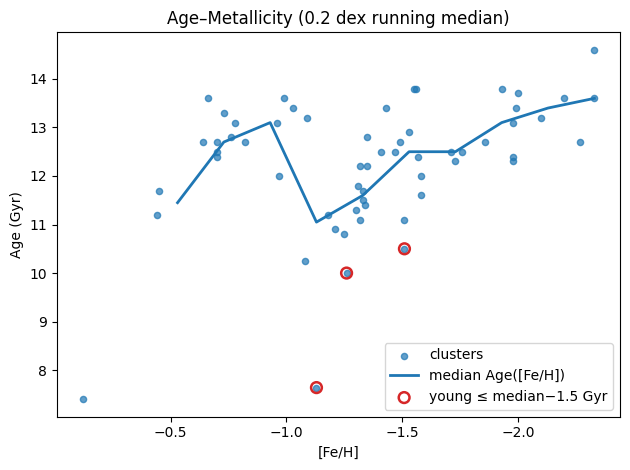

In [347]:
# Columns to plot
feh = "_FeH" if "_FeH" in df.columns else ("FeH" if "FeH" in df.columns else "[Fe/H]")
age = "_Age" if "_Age" in df.columns else ("Age" if "Age" in df.columns else "Age_KR")

X = pd.to_numeric(df[feh], errors="coerce")
Y = pd.to_numeric(df[age], errors="coerce")
m = X.notna() & Y.notna()

sub = df.loc[m, ["ID" if "ID" in df.columns else "ID_H1"]].copy()
sub["x"] = X[m].values
sub["y"] = Y[m].values

# Fixed-width bins (0.2 dex) and median per bin
bins = np.arange(sub["x"].min() - 0.1, sub["x"].max() + 0.11, 0.2)
sub["bin"] = pd.cut(sub["x"], bins, include_lowest=True)
med_by_bin = sub.groupby("bin")["y"].median()
bin_centers = med_by_bin.index.map(lambda iv: (iv.left + iv.right) / 2)

# Strict “young-for-metallicity”: <= median − 1.5 Gyr
sub["med_age"] = sub.groupby("bin")["y"].transform("median")
sub["young"]   = sub["y"] <= (sub["med_age"] - 1.5)

# Plot
plt.figure()
plt.scatter(sub["x"], sub["y"], s=20, alpha=0.7, label="clusters")
plt.plot(bin_centers, med_by_bin.values, lw=2, label="median Age([Fe/H])")
plt.scatter(sub.loc[sub["young"], "x"], sub.loc[sub["young"], "y"],
            s=60, facecolors="none", edgecolors="C3", linewidths=1.8,
            label="young ≤ median−1.5 Gyr")
plt.gca().invert_xaxis()
plt.xlabel("[Fe/H]"); plt.ylabel("Age (Gyr)")
plt.title("Age–Metallicity (0.2 dex running median)")
plt.legend(); plt.tight_layout()
plt.savefig("age_metallicity.png", dpi=200)

# Save strict young flags aligned to df
young = pd.Series(False, index=df.index)
young.loc[sub.index] = sub["young"].values
young.to_csv("young_flag.csv", header=["young"])
print("Strict AMR young flagged:", int(young.sum()))

B: rotation frequency

Strict kinematic outliers (>2σ): 8


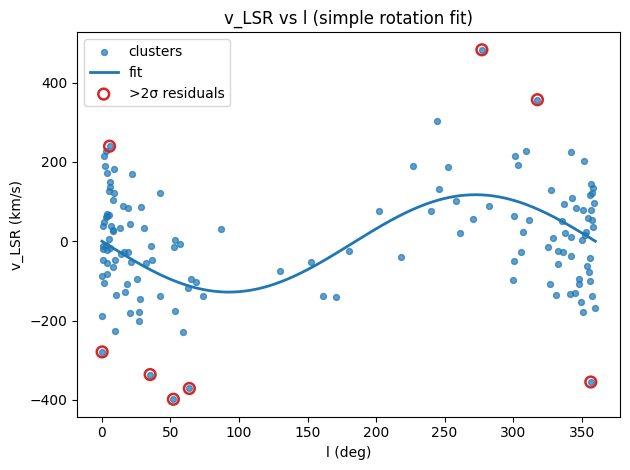

In [348]:
# Need l, b (deg) and v_LSR (km/s)
if all(c in df.columns for c in ["L","B","v_LSR"]):
    L = pd.to_numeric(df["L"], errors="coerce") * np.pi/180.0
    B = pd.to_numeric(df["B"], errors="coerce") * np.pi/180.0
    V = pd.to_numeric(df["v_LSR"], errors="coerce")
    k = L.notna() & B.notna() & V.notna()

    # Design matrix for A*sin(l) + B*cos(l) + C
    A_mat = np.column_stack([np.sin(L[k].values), np.cos(L[k].values), np.ones(k.sum())])
    coefs, *_ = np.linalg.lstsq(A_mat, V[k].values, rcond=None)
    A_sin, B_cos, C_off = coefs

    Vfit   = A_mat @ coefs
    resid  = V[k].values - Vfit
    sigma  = float(np.nanstd(resid))

    # Smooth model curve for plotting
    lgrid = np.linspace(0, 2*np.pi, 721)
    vgrid = A_sin*np.sin(lgrid) + B_cos*np.cos(lgrid) + C_off

    ldeg = np.degrees(L[k].values)
    plt.figure()
    plt.scatter(ldeg, V[k].values, s=18, alpha=0.7, label="clusters")
    plt.plot(np.degrees(lgrid), vgrid, lw=2, label="fit")
    plt.scatter(ldeg[np.abs(resid) > 2.0*sigma], V[k].values[np.abs(resid) > 2.0*sigma],
                s=60, facecolors="none", edgecolors="C3", linewidths=1.8, label=">2σ residuals")
    plt.xlabel("l (deg)"); plt.ylabel("v_LSR (km/s)")
    plt.title("v_LSR vs l (simple rotation fit)")
    plt.legend(); plt.tight_layout()
    plt.savefig("vlsr_vs_l_fit.png", dpi=200)

    # Save strict kinematic outliers (>2σ)
    id_col = "ID_H1" if "ID_H1" in df.columns else "ID"
    ktab = df.loc[k, [id_col, "L", "B", "v_LSR"]].copy()
    ktab["resid"] = resid
    kin_strict = ktab[np.abs(ktab["resid"]) > 2.0*sigma]
    kin_strict.to_csv("candidates_kin_only_strict.csv", index=False)

    print("Strict kinematic outliers (>2σ):", len(kin_strict))
else:
    print("Missing columns for kinematics (need L, B, v_LSR).")


Candidates list -

In [349]:
# Read back strict lists and form intersection by ID
id_col = "ID_H1" if "ID_H1" in df.columns else "ID"

amr_strict_ids = set(df.loc[young.values, id_col].astype(str))
try:
    kin_tab = pd.read_csv("candidates_kin_only_strict.csv")
    kin_ids = set(kin_tab[id_col].astype(str))
except FileNotFoundError:
    kin_ids = set()

both_strict_ids = amr_strict_ids.intersection(kin_ids)
both_mask = df[id_col].astype(str).isin(both_strict_ids)

cols = [c for c in [id_col, "_FeH", "_Age", "FeH", "Age", "v_LSR", "L", "B", "R_gc", "R_G"] if c in df.columns]

# Save tidy tables (strict)
df.loc[df[id_col].astype(str).isin(amr_strict_ids), cols].to_csv("candidates_amr_only_strict.csv", index=False)
df.loc[df[id_col].astype(str).isin(kin_ids),        cols].to_csv("candidates_kin_only_strict.csv", index=False)  # overwrite with tidy cols
df.loc[both_mask,                                    cols].to_csv("candidates_both_strict.csv", index=False)

print("Strict intersection (AMR ∧ KIN):", int(both_mask.sum()))


Strict intersection (AMR ∧ KIN): 0


In [350]:
# AMR figure with strict ∧ circled (only if any)
ids = set(df.loc[both_mask, id_col].astype(str))
if len(ids) > 0:
    is_cand = df.loc[m, id_col].astype(str).isin(ids).values

    plt.figure()
    plt.scatter(sub["x"], sub["y"], s=20, alpha=0.7, label="clusters")
    plt.plot(bin_centers, med_by_bin.values, lw=2, label="median Age([Fe/H])")
    plt.scatter(sub.loc[is_cand,"x"], sub.loc[is_cand,"y"],
                s=80, facecolors="none", edgecolors="C3", linewidths=2.0, label="strict ∧")
    plt.gca().invert_xaxis()
    plt.xlabel("[Fe/H]"); plt.ylabel("Age (Gyr)")
    plt.title("Age–Metallicity (strict ∧ candidates)")
    plt.legend(); plt.tight_layout()
    plt.savefig("age_metallicity_candidates_strict.png", dpi=200)


In [351]:
# AMR figure with strict ∧ circled (only if any)
ids = set(df.loc[both_mask, id_col].astype(str))
if len(ids) > 0:
    is_cand = df.loc[m, id_col].astype(str).isin(ids).values

    plt.figure()
    plt.scatter(sub["x"], sub["y"], s=20, alpha=0.7, label="clusters")
    plt.plot(bin_centers, med_by_bin.values, lw=2, label="median Age([Fe/H])")
    plt.scatter(sub.loc[is_cand,"x"], sub.loc[is_cand,"y"],
                s=80, facecolors="none", edgecolors="C3", linewidths=2.0, label="strict ∧")
    plt.gca().invert_xaxis()
    plt.xlabel("[Fe/H]"); plt.ylabel("Age (Gyr)")
    plt.title("Age–Metallicity (strict ∧ candidates)")
    plt.legend(); plt.tight_layout()
    plt.savefig("age_metallicity_candidates_strict.png", dpi=200)


In [352]:
# Load candidates (lenient ∧)
cand = pd.read_csv("candidates_both_lenient.csv")

# Pick the ID column that exists
id_col = "ID_H1" if "ID_H1" in cand.columns else "ID"

# Columns to show (keep only those that exist)
cols_order = [id_col, "_FeH", "_Age", "v_LSR", "L", "B", "R_gc", "R_G"]
cols_show  = [c for c in cols_order if c in cand.columns]

# Tidy copy
out = cand[cols_show].copy()

# Make numeric where appropriate (so it prints nicely / sorts correctly)
for c in ["_FeH","_Age","v_LSR","L","B","R_gc","R_G"]:
    if c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce")

# Optional: round numeric columns for the README/table
num_cols = [c for c in out.columns if c != id_col]
out[num_cols] = out[num_cols].round(2)

# Print and save (current folder)
print(out)
out.to_csv("results_lenient_intersection.csv", index=False)
print("Saved results_lenient_intersection.csv with", len(out), "rows")

      ID_H1  _FeH  _Age  R_gc
0  NGC 1851 -1.13  7.64  16.6
Saved results_lenient_intersection.csv with 1 rows


Create one CSV with the chemistry flag (young-for-metallicity), the kinematic residual (and σ), plus the AND/OR selections.

residuals histogram